# Multiclass classification

In [1]:
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute
from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import preprocess_chunks_for_multiclass_test_one_handed, concat_chunks_for_feature_extraction, \
    segment_for_null_classification, preprocess_chunks_for_null_test


sample_rate = 50


Bad key "text.kerning_factor" on line 4 in
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
use_fingerprinting = True
window_size = 100
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

selected_activities = ['checking oven',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door']

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2", "Anne", "Ariane", "Cilly", "Fabi", "Jonas", "Julian", "Julius","Marvin", "Wiktoria"]
#experiment_dirs_selected = ["Julius"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]

Preprocess data

In [10]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True, selected_activities=selected_activities)

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
chunks_ocd, chunks_null_class, y_ocd = preprocess_chunks_for_multiclass_test_one_handed(chunks, null_chunks, y, use_indoor)
#chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks, use_indoor)
#y_ocd = y

In [23]:
chunks_ocd[1]

,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id
index,,,,,,,
00:00:50.009891,0.299355,-0.404462,0.298486,5.319927,5.084093,6.251681,1
00:00:50.029891,0.283659,-0.564500,0.363297,5.428931,4.955667,6.628238,1
00:00:50.049891,0.228926,-0.545697,0.365058,5.185529,5.136183,6.784716,1
00:00:50.069891,0.253488,-0.502188,0.322827,5.602077,5.305484,6.513440,1
00:00:50.089891,0.278720,-0.694445,0.410786,5.761780,5.498893,6.192763,1
...,...,...,...,...,...,...,...
00:00:54.789891,-0.029257,0.055905,-0.072715,2.734126,4.664709,8.253884,1
00:00:54.809891,-0.021256,0.084662,-0.093862,2.647030,4.763625,8.169458,1
00:00:54.829891,-0.023252,0.088731,-0.097459,2.651617,4.834449,8.185848,1


In [12]:
labels = y_ocd.loc[:, "label"].squeeze()
assert len(labels) == len(chunks_ocd)

labels_ocd_multiclass = labels.reset_index(drop=True)
chunks_ocd_segmented, labels_ocd_segmented_multiclass, chunks_null_segmented, labels_null_segmented = segment_for_null_classification(chunks_ocd, chunks_null_class, window_size, labels)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["combined_id"] = [(action_id, i)] * len(c_new)
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [action_id] * len(c_new)
/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segment

In [13]:
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

assert len(labels_multi_class_classification) == len(chunks_ocd_segmented) + len(chunks_null_segmented)
assert len(multi_class_df.loc[:, "combined_id"].unique()) == len(chunks_ocd_segmented) + len(chunks_null_segmented)

assert len(set(labels_multi_class_classification)) == labels.nunique() +1
# without null class
"""
multi_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass))
"""

'\nmulti_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(\n        [chunks_ocd_segmented],\n        [labels_ocd_segmented_multiclass])\nassert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass))\n'

In [14]:
# the one handed activities
assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',}

### Feature extraction for multi class OCD activities incl null

In [15]:
X_multi_class_classification = extract_timeseries_features(multi_class_df, use_indoor=use_indoor, use_fingerprinting_approach=use_fingerprinting, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


### Feature selection for multi class OCD activities incl null

In [16]:
X_multi_class_classification.head()
# TODO: something seems to be weird about the length of the chunks. Some have a length of 200, others 100 and others only 50


impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)

In [17]:
X_multi_class_classification_selected

,acceleration y__maximum,acceleration y__sum_values,acceleration y__mean,acceleration y__median,acceleration x__standard_deviation,acceleration x__variance,acceleration x__maximum,acceleration y__minimum,4,10,...,gyroscope x__maximum,acceleration x__minimum,8,acceleration z__minimum,5,3,7,acceleration z__median,acceleration z__mean,acceleration z__sum_values
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",9.034533,890.380727,8.903807,8.903473,0.076651,0.005875,3.018556,8.812905,-120.00,-120.00,...,0.034231,2.700855,-118.200000,1.183128,-107.425000,-107.650,-76.533333,1.315432,1.312364,131.236403
"(1, 0)",10.107365,881.224082,8.812241,9.026211,1.364657,1.862288,6.746671,5.727617,-112.50,-120.00,...,0.186301,1.554778,-88.666667,0.362865,-70.458333,-78.625,-60.500000,0.843856,1.606024,160.602365
"(2, 0)",9.615560,483.477281,4.834773,3.886258,2.104700,4.429761,11.548149,1.720780,-118.65,-120.00,...,0.666910,1.675894,-82.750000,-1.158449,-66.725000,-80.150,-62.050000,4.055328,4.376831,437.683063
"(3, 0)",7.663223,482.920393,4.829204,4.935862,1.741601,3.033176,8.772442,1.335395,-120.00,-120.00,...,1.004727,1.246065,-110.250000,1.688758,-66.125000,-120.000,-58.083333,5.000395,5.486489,548.648893
"(4, 0)",7.790021,448.566193,4.485662,4.629648,1.075353,1.156385,9.265230,1.897528,-112.25,-120.00,...,0.270108,3.575359,-94.050000,2.367111,-65.033333,-89.175,-77.325000,5.288734,5.400817,540.081659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3171, 3)",2.268723,220.503228,2.205032,2.209310,0.038925,0.001515,8.985812,2.107899,-111.35,-95.50,...,0.025298,8.818241,-101.233333,3.350751,-62.600000,-100.850,-79.700000,3.452683,3.461834,346.183358
"(3172, 0)",2.244207,218.441009,2.184410,2.186990,0.026649,0.000710,9.025860,2.117635,-120.00,-100.75,...,0.010224,8.874763,-100.666667,3.296223,-62.125000,-89.125,-75.041667,3.373928,3.367413,336.741297
"(3173, 0)",2.238232,217.634699,2.176347,2.181687,0.036259,0.001315,9.063495,2.100070,-120.00,-120.00,...,0.028250,8.884076,-92.566667,3.196988,-59.683333,-104.075,-72.883333,3.274779,3.271661,327.166092


In [17]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

### Train models and score results

Multi class classification: using indoor: True; FC params: MinimalFCParameters; window_size 100
NB: 0.36 +/- 0.07
LDA: 0.93 +/- 0.01
CART: 0.83 +/- 0.04
Logistic Regression: 0.94 +/- 0.00
Random Forest: 0.93 +/- 0.01


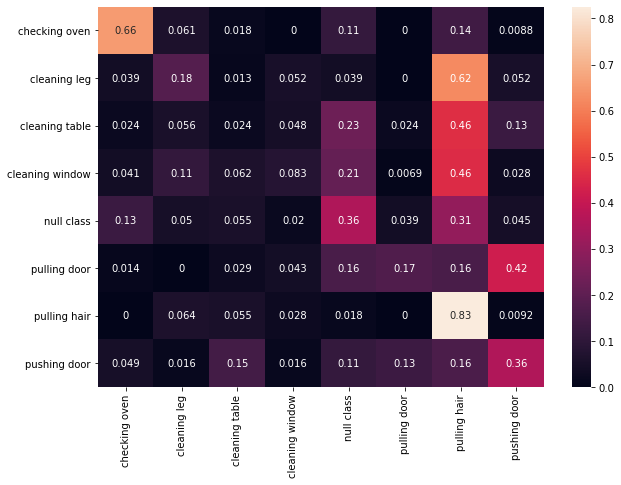

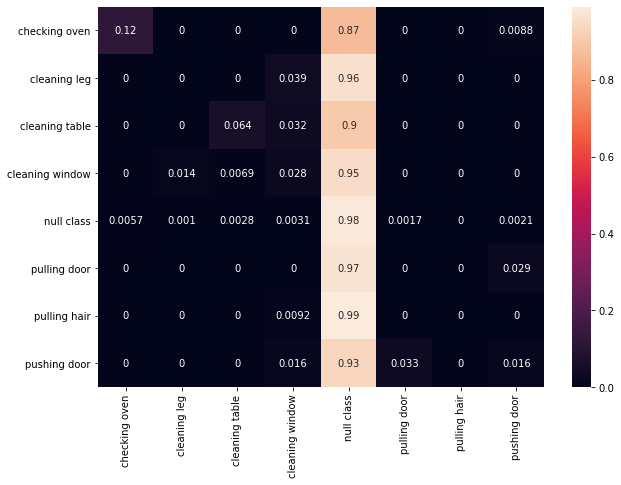

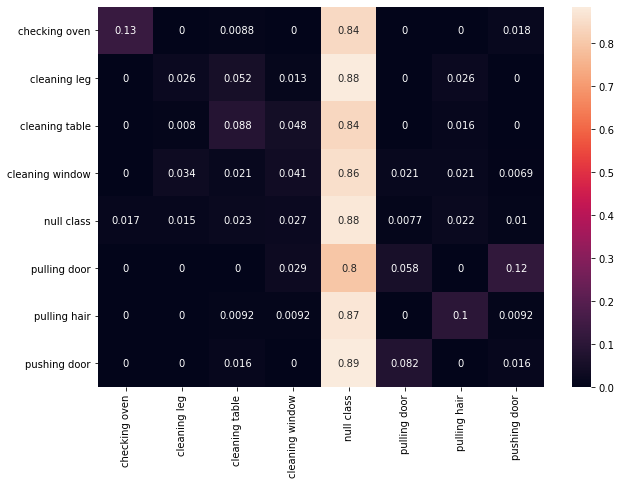

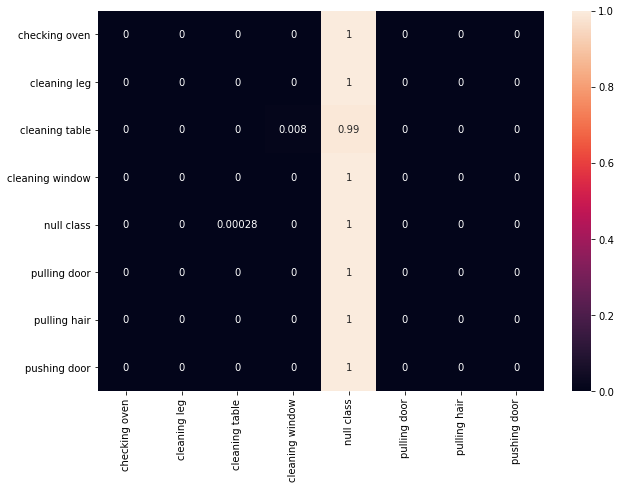

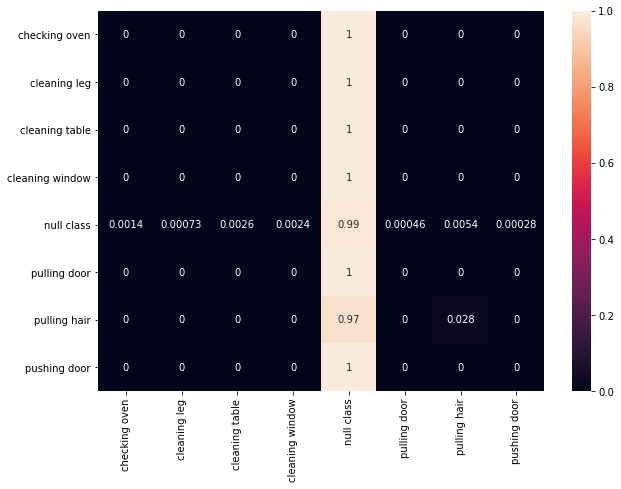

In [18]:
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification, path=None, binary=False)

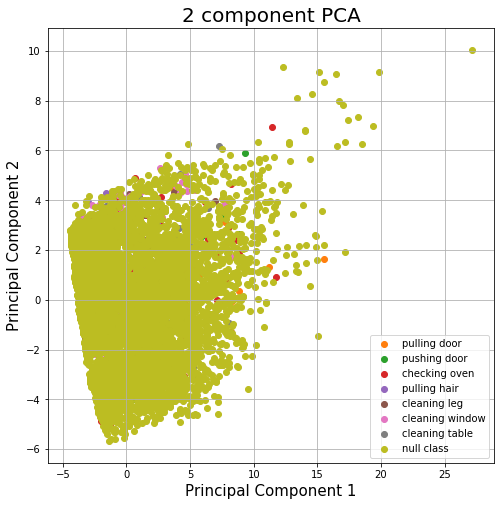

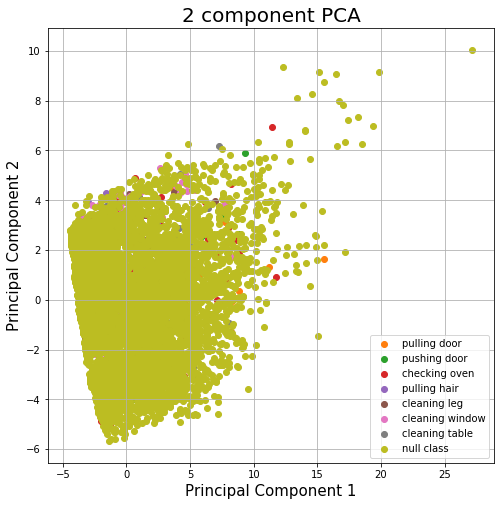

In [22]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])


In [36]:
labels_multi_class_classification.unique()

array(['pulling door', 'pushing door', 'checking oven', 'pulling hair',
       'cleaning leg', 'cleaning window', 'cleaning table', 'null class'],
      dtype=object)

In [41]:
len(labels_null_segmented)/ len(labels_multi_class_classification)

0.9197711548696115